In [403]:
import matplotlib.pyplot as plt
import numpy as np
#v. 20220728.1
filedir = './data/'
outputdir = './output/'
filenames = ['24.ASC']
fs = 500                        # частота дискретизации, Гц
first_stim_start_time = 1       # начало первого стимула, с
period = 8                      # период следования стимулов, с
background_start_time = 5       # начало фоновой засветки, с
background_duration = 20        # длительность фоновой засветки, с
sign = -1                       # полярность {1:'стимулы вверх', -1:'стимулы вниз'}
low_cutoff = 0.1                # частота среза highpass фильтра, Гц
stim_maximums_to_delete = []    # номера неудачных стимулов (перечислить через запятую)
# начало первого импульса после фоновой засветки
after_background_start_time = first_stim_start_time + ((background_start_time + background_duration - first_stim_start_time) // period + 1) * period

In [404]:
# Чтение сигнала из файла(ов)
signal = []
for filename in filenames:
    with open(filedir + filename, 'r', encoding='utf-8') as file:
        file.readline()
        line = file.readline()
        while line and line[0] == '"':
            line = file.readline()
        signal.append(sign * float('0' if line == '.\n' else line))
        for line in file:
            signal.append(sign * float('0' if line == '.\n' else line))
signal = np.array(signal)

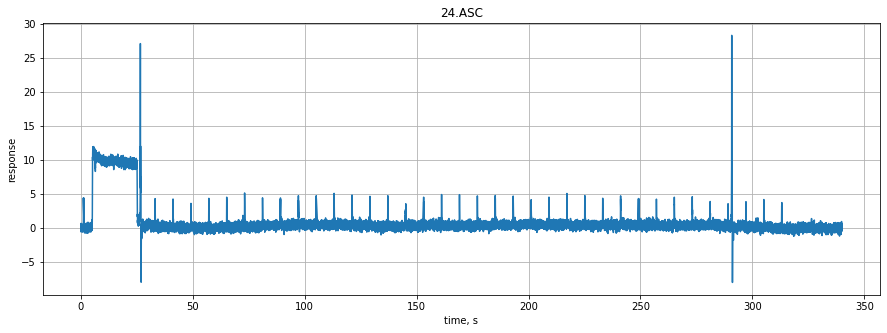

In [405]:
# Построение графика сигнала
n = signal.size
t = np.linspace(0, (n - 1) / fs, n)
fig, ax = plt.subplots()
ax.plot(t, signal)
fig.set_figwidth(15)
fig.set_figheight(5)
ax.set_xlabel('time, s')
ax.set_ylabel('response')
ax.set_title(','.join(filenames))
ax.grid()

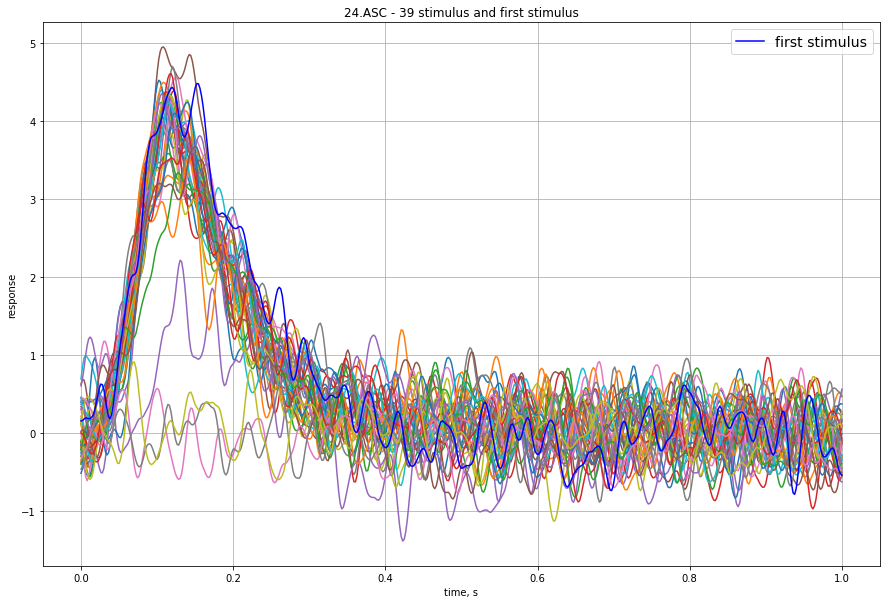

In [406]:
stims_cnt = ((n - 1) // fs - after_background_start_time) // period + 1
stims = []
prefix = fs // 5 # 0.2 секунды слева от стимула используются для расчета тренда
postfix = fs // 5 # последние 0.2 секунды стимула используются для расчета тренда
size = fs + prefix

# вычитание тренда из стимулов
for i in range(stims_cnt):
    begin = after_background_start_time * fs + period * i * fs - prefix
    end = begin + size
    stim = np.array(signal[begin:end])
    temp_t = np.linspace(0, (size - 1), size)
    x = np.concatenate([temp_t[:prefix], temp_t[size - postfix:]])
    y = np.concatenate([stim[:prefix], stim[size - postfix:]])
    s = np.polynomial.polynomial.Polynomial.fit(x, y, 1).convert().coef
    k, b = s[1], s[0]
    trend = k * temp_t + b
    stim = stim - trend
    stim = stim[prefix:]
    stims.append(stim)

# вычитание тренда из первого стимула
begin = first_stim_start_time * fs - prefix
end = begin + size
first_stim = np.array(signal[begin:end])
temp_t = np.linspace(0, (size - 1), size)
x = np.concatenate([temp_t[:prefix], temp_t[size - postfix:]])
y = np.concatenate([first_stim[:prefix], first_stim[size - postfix:]])
s = np.polynomial.polynomial.Polynomial.fit(x, y, 1).convert().coef
k, b = s[1], s[0]
trend = k * temp_t + b
first_stim = first_stim - trend
first_stim = first_stim[prefix:]
first_stim_max = first_stim.max()

size -= prefix
temp_t = np.linspace(0, 1, size)
fig, ax = plt.subplots()
for stim in stims:
    ax.plot(temp_t, stim)
ax.plot(temp_t, first_stim, 'b', label='first stimulus')
ax.legend(prop={"size": 14})
fig.set_figwidth(15)
fig.set_figheight(10)
ax.set_xlabel('time, s')
ax.set_ylabel('response')
ax.set_title(f'{",".join(filenames)} - {stims_cnt} stimulus and first stimulus')
ax.grid()

Номер	Время	Максимум
0	8.0	4.2176
1	16.0	4.1084
2	24.0	3.6355
3	32.0	4.3852
4	40.0	4.3321
5	48.0	4.9495
6	56.0	4.0416
7	64.0	3.9469
8	72.0	4.2679
9	80.0	4.3978
10	88.0	4.5223
11	96.0	4.4962
12	104.0	4.3513
13	112.0	4.3747
14	120.0	2.2157
15	128.0	4.1919
16	136.0	4.5586
17	144.0	4.6983
18	152.0	4.3396
19	160.0	4.3087
20	168.0	4.2400
21	176.0	3.6197
22	184.0	4.0663
23	192.0	4.6081
24	200.0	4.2951
25	208.0	4.0635
26	216.0	4.2535
27	224.0	3.8131
28	232.0	3.8288
29	240.0	4.2302
30	248.0	4.2433
31	256.0	3.5315
32	264.0	3.3378
33	272.0	3.8649
34	280.0	4.3497
35	288.0	3.6739
36	296.0	0.7431
37	304.0	0.9586
38	312.0	0.9106
Не удалось выполнить аппроксимацию. Подберите начальные коэффициенты.


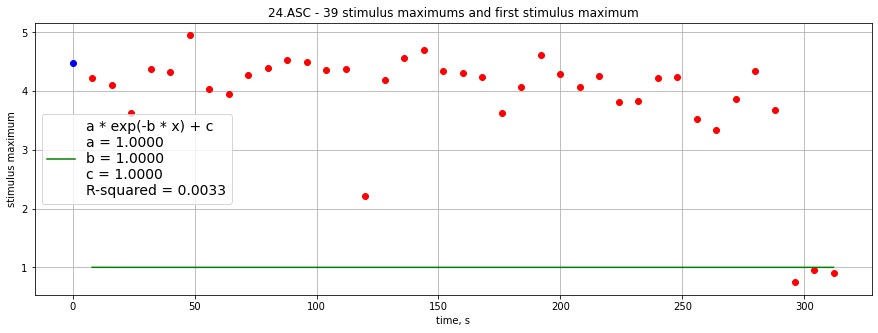

In [407]:
# Аппроксимация максимумов стимулов экспонентой
from scipy import stats, optimize

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

stim_maximums = np.array([stim.max() for stim in stims])

# Считается расстояние между началом первого импульса после фоновой засветки и ее концом
# График максимумов стимулов начинает строится в точке, равной рассчитанному расстоянию
begin = after_background_start_time - background_start_time - background_duration
end = begin + (stims_cnt - 1) * period
stim_maximums_x = np.linspace(begin, end, stims_cnt)

print('Номер\tВремя\tМаксимум')
for i, (x, stim_maximum) in enumerate(zip(stim_maximums_x, stim_maximums)):
    print(f'{i}\t{x}\t{stim_maximum:.4f}')

# Удаление неудачных максимумов стимулов
stim_maximums = np.delete(stim_maximums, stim_maximums_to_delete)
stim_maximums_x = np.delete(stim_maximums_x, stim_maximums_to_delete)

popt = (1, 1, 1)
try:
    popt, pcov = optimize.curve_fit(func, stim_maximums_x, stim_maximums, [-0.05, 0.01, 0.05])
except RuntimeError:
    print('Не удалось выполнить аппроксимацию. Подберите начальные коэффициенты.')
exp_a = popt[0]
exp_b = popt[1]
exp_c = popt[2]
fit = func(stim_maximums_x, *popt)
rvalue = stats.linregress(stim_maximums, fit).rvalue
r_squared = rvalue ** 2

fig, ax = plt.subplots()
ax.plot(stim_maximums_x, stim_maximums, 'ro')
ax.plot(0, first_stim_max, 'bo')
ax.plot(stim_maximums_x, fit, 'g', label=f'a * exp(-b * x) + c\n'
                           f'a = {exp_a:.4f}\n'
                           f'b = {exp_b:.4f}\n'
                           f'c = {exp_c:.4f}\n'
                           f'R-squared = {r_squared:.4f}')
fig.set_figwidth(15)
fig.set_figheight(5)
ax.set_xlabel('time, s')
ax.set_ylabel('stimulus maximum')
ax.set_title(f'{",".join(filenames)} - {stim_maximums.size} stimulus maximums and first stimulus maximum')
ax.legend(prop={"size": 14})
ax.grid()

In [408]:
# Сохранение результатов в файл
from pathlib import Path

Path(outputdir).mkdir(parents=True, exist_ok=True)
with open(f'{outputdir}{",".join(filenames)}_out.txt', 'w', encoding='utf-8') as file:
    file.write(f'Файл(ы)\t{",".join(filenames)}\n')
    file.write(f'Длительность фона, c\t{background_duration}\n')
    file.write(f'Период следования стимулов, с\t{period}\n')
    file.write(f'Длительность записи, с\t{(n - 1) / fs}\n')
    file.write(f'Частота дискретизации, Гц\t{fs}\n')
    file.write(f'Параметр экспоненты a\t{exp_a:.4f}\n')
    file.write(f'Параметр экспоненты b\t{exp_b:.4f}\n')
    file.write(f'Параметр экспоненты c\t{exp_c:.4f}\n')
    file.write(f'Постоянная времени 1/b\t{1 / exp_b:.4f}\n')
    file.write(f'R-squared\t{r_squared:.4f}\n')
    file.write('\n')
    file.write('time, с\tU, у.е\tфункция аппроксимации (a * exp(-b * x) + c)\n')
    file.write(f'{0}\t{first_stim_max}\n')
    for i in range(stim_maximums.size):
        file.write(f'{stim_maximums_x[i]}\t{stim_maximums[i]}\t{fit[i]}\n')

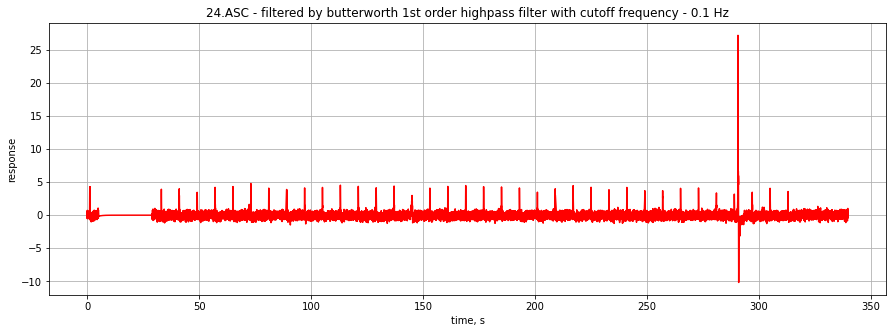

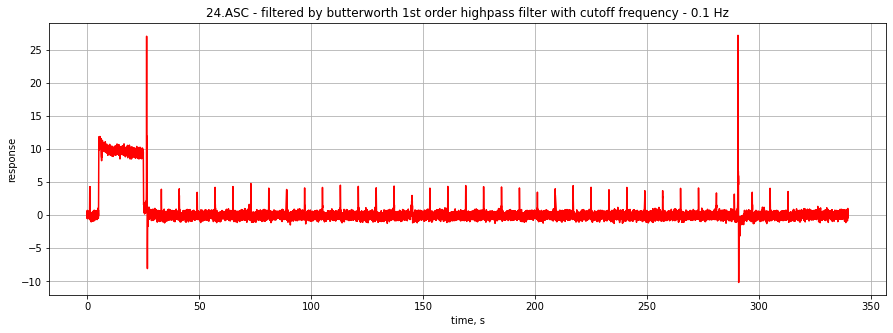

In [409]:
# Следующий блок кода используется только в целях красивого построения графика сигнала, отфильтрованного highpass фильтром Баттерворта.
# В расчетах максимумов стимулов и экспоненты отфильтрованный сигнал не участвует,
# так как фильтр немного обрезает максимум стимулов и добавляет отрицательный зубец на нисходящем фронте стимула

# Смещение сигнала до начала фона к 0
signal[:background_start_time * fs] -= signal[:first_stim_start_time * fs].mean()
begin = background_start_time * fs
end = after_background_start_time * fs - (after_background_start_time - background_start_time - background_duration) * fs // 2
# Копия фона - необходима, чтобы его потом нарисовать вместе с отфильтрованным сигналом
background = np.array(signal[begin:end])
# Смещение сигнала после окончания фона к 0
signal[end:] -= signal[end:after_background_start_time * fs].mean()
# Удаление фона, для того чтобы избежать переходного процесса фильтра после него и измерить высоту первого после него стимула
signal[begin:end] = 0

from scipy.signal import butter, lfilter
nyq = 0.5 * fs
b, a = butter(1, low_cutoff / nyq, btype='highpass', analog=False)
filtered = lfilter(b, a, signal)
fig, ax = plt.subplots()
ax.plot(t, filtered, 'r')
fig.set_figwidth(15)
fig.set_figheight(5)
ax.set_xlabel('time, s')
ax.set_ylabel('response')
ax.set_title(f'{",".join(filenames)} - filtered by butterworth 1st order highpass filter with cutoff frequency - {low_cutoff} Hz')
ax.grid()

# Возврат ступеньки, смещенной к нулю, в отфильтрованный сигнал, просто чтобы ее нарисовать
begin = background_start_time * fs
end = after_background_start_time * fs - (after_background_start_time - background_start_time - background_duration) * fs // 2
filtered[begin:end] = background - background[0]
fig, ax = plt.subplots()
ax.plot(t, filtered, 'r')
fig.set_figwidth(15)
fig.set_figheight(5)
ax.set_xlabel('time, s')
ax.set_ylabel('response')
ax.set_title(f'{",".join(filenames)} - filtered by butterworth 1st order highpass filter with cutoff frequency - {low_cutoff} Hz')
ax.grid()